<a href="https://colab.research.google.com/github/ArmandDS/blog-post/blob/main/NER_whisper_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Named Entity Recognition
Information Extraction
Detect and classify the named entities in biomedical data using OpenAI whisper to xtract text from audio


Install required Libraries

In [ ]:
!pip -qq install --upgrade youtube-dl
!pip -qq install git+https://github.com/openai/whisper.git 
!pip -qq install transformers
!pip -qq install sentencepiece
!pip -qq install spacy-transformers

     |████████████████████████████████| 1.9 MB 34.7 MB/s 
     |████████████████████████████████| 4.9 MB 8.4 MB/s 
     |████████████████████████████████| 163 kB 54.3 MB/s 
     |████████████████████████████████| 6.6 MB 57.1 MB/s 
     |████████████████████████████████| 1.3 MB 27.3 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 4.7 MB 65.5 MB/s 
     |████████████████████████████████| 1.1 MB 52.6 MB/s 


Load the required libraries

In [ ]:
import random
import json 
import pandas as pd
import os
from tqdm import tqdm, tqdm_notebook
import torch
import time
from os.path import exists as path_exists
from pathlib import Path

#Spacy 
import spacy
from spacy.tokens import DocBin
from spacy.util import minibatch
from spacy.training import Example
from spacy.scorer import Scorer
from spacy.lang.es import Spanish
from spacy.pipeline import EntityRuler

#huggingface
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import AutoModelForSeq2SeqLM

#whisper
import whisper


# Preprocesing the Dataset

Go to kaggle and download the [medical records dataset](https://www.kaggle.com/tboyle10/medicaltranscriptions) as zip, and the we load as pandas dataframe:

In [ ]:
df = pd.read_csv("/content/archive.zip")
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer_t = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")

model_t = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-es")

/usr/local/lib/python3.7/dist-packages/transformers/models/marian/tokenization_marian.py:198: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Send the model to GPU if available

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_t = model_t.to(device)

Define a function to translate text to spanish

In [ ]:
def translate(text:str):
  inputs = tokenizer_t.encode( text, return_tensors="pt",padding=True,max_length=512,truncation=True)
  inputs = inputs.to(device)
  outputs = model_t.generate(
      inputs, max_length=512, num_beams=None, early_stopping=True)
  translated = tokenizer_t.decode(outputs[0]).replace('<pad>',"").replace('<s>',"").replace('</s>',"").strip().lower()

  return translated

In [ ]:
df.tail()['description'].apply(translate)

4994    paciente con sinusitis severa hace unos dos o ...
4995    se trata de un bebé caucásico de 14 meses de e...
4996    una hembra para un examen físico completo y se...
4997       madre dice que ha estado sibilando y tosiendo.
4998    reacción alérgica aguda, etiología incierta, s...
Name: description, dtype: object

Filter the dataset by the columns "medical_specialty"

In [ ]:
filtered_df = df[['transcription', 'medical_specialty']]
filtered_df.loc[:, 'medical_specialty'] = filtered_df['medical_specialty'].apply(lambda x:str.strip(x))
mask = (filtered_df['medical_specialty'] == 'SOAP / Chart / Progress Notes') | \
       (filtered_df['medical_specialty'] == 'Office Notes') | \
       (filtered_df['medical_specialty'] == 'Consult - History and Phy.') | \
       (filtered_df['medical_specialty'] == 'Emergency Room Reports') | \
       (filtered_df['medical_specialty'] == 'Discharge Summary') | \
       (filtered_df['medical_specialty'] == 'Letters')
filtered_df = filtered_df[~mask]
data_categories  = filtered_df.groupby(filtered_df['medical_specialty'])
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [ ]:
filtered_data_categories['medical_specialty'].value_counts()

Surgery                       1103
Cardiovascular / Pulmonary     372
Orthopedic                     355
Radiology                      273
General Medicine               259
Gastroenterology               230
Neurology                      223
Obstetrics / Gynecology        160
Urology                        158
ENT - Otolaryngology            98
Neurosurgery                    94
Hematology - Oncology           90
Ophthalmology                   83
Nephrology                      81
Pediatrics - Neonatal           70
Pain Management                 62
Psychiatry / Psychology         53
Name: medical_specialty, dtype: int64

In [ ]:
df_cleaned = filtered_data_categories.sample(frac=1.0)
df_cleaned = df_cleaned.dropna(subset=['transcription'])
df_cleaned.head()

,transcription,medical_specialty
2922,"EXAM: , CT head without contrast.,INDICATIONS:...",Neurology
2710,"PREOPERATIVE DIAGNOSES:,1. Epidural hematoma,...",Neurosurgery
645,"PREOPERATIVE DIAGNOSIS: , Chronic cholecystiti...",Surgery
808,"PREOPERATIVE DIAGNOSIS:, Left supraorbital de...",Surgery
4852,"DIAGNOSIS AT ADMISSION:, Chronic obstructive ...",Cardiovascular / Pulmonary


Label the NER in English using the huggingface model for biomedical

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)

In [ ]:
tqdm_notebook().pandas()
df_cleaned['ner_en']  = df_cleaned['transcription'].progress_apply(pipe)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


0it [00:00, ?it/s]

  0%|          | 0/3732 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1039: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [ ]:
df_cleaned.head()

,transcription,medical_specialty,ner_en
2922,"EXAM: , CT head without contrast.,INDICATIONS:...",Neurology,"[{'entity_group': 'Diagnostic_procedure', 'sco..."
2710,"PREOPERATIVE DIAGNOSES:,1. Epidural hematoma,...",Neurosurgery,"[{'entity_group': 'Biological_structure', 'sco..."
645,"PREOPERATIVE DIAGNOSIS: , Chronic cholecystiti...",Surgery,"[{'entity_group': 'Disease_disorder', 'score':..."
808,"PREOPERATIVE DIAGNOSIS:, Left supraorbital de...",Surgery,"[{'entity_group': 'Biological_structure', 'sco..."
4852,"DIAGNOSIS AT ADMISSION:, Chronic obstructive ...",Cardiovascular / Pulmonary,"[{'entity_group': 'Detailed_description', 'sco..."


Create the dictionary as helper for our text proccesing

In [ ]:
dict_specialty_keywords = {}
dict_specialty_keywords_es = {}


def create_dict(list_elem):
    for elem in list_elem:
      if elem['entity_group'] in dict_specialty_keywords:
        dict_specialty_keywords[elem['entity_group']].append(elem['word'])
        dict_specialty_keywords_es[elem['entity_group']].append(translate(elem['word']))
      else:
        dict_specialty_keywords[elem['entity_group']] = [elem['word']]
        dict_specialty_keywords_es[elem['entity_group']] = [translate(elem['word'])]

Translate the annotations to Spanish

In [ ]:
tqdm_notebook().pandas()

_ = df_cleaned['ner_en'].progress_apply(create_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


0it [00:00, ?it/s]

  0%|          | 0/3732 [00:00<?, ?it/s]

In [ ]:
with open("ner_annotations_es.json", 'w') as f:
    json.dump(dict_specialty_keywords_es, f) 

Translate the transcriptions to Spanish

In [ ]:
tqdm_notebook().pandas()

df_cleaned['transcription_es'] = df_cleaned['transcription'].progress_apply(translate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


0it [00:00, ?it/s]

  0%|          | 0/3732 [00:00<?, ?it/s]

In [ ]:
df_cleaned.to_csv("df_cleaned.csv")

# Create the annotated dataset

In [ ]:
dict_specialty_keywords_es = json.load(open("/content/ner_annotations_es.json"))

dict_specialty_keywords_es.keys()

dict_keys(['Age', 'Sex', 'History', 'Duration', 'Sign_symptom', 'Biological_structure', 'Detailed_description', 'Severity', 'Medication', 'Lab_value', 'Diagnostic_procedure', 'Nonbiological_location', 'Dosage', 'Clinical_event', 'Disease_disorder', 'Administration', 'Therapeutic_procedure', 'Coreference', 'Distance', 'Family_history', 'Time', 'Area', 'Date', 'Color', 'Subject', 'Personal_background', 'Occupation', 'Activity', 'Qualitative_concept', 'Outcome', 'Frequency', 'Quantitative_concept', 'Other_entity', 'Volume', 'Shape', 'Texture', 'Other_event', 'Height'])

Cleaning the dictionay data

In [ ]:
for k in dict_specialty_keywords_es.keys():
  dict_specialty_keywords_es[k] = set(dict_specialty_keywords_es[k])

In [ ]:
for k in dict_specialty_keywords_es.keys():
  dict_specialty_keywords_es[k] = [el.strip() for el in list(dict_specialty_keywords_es[k]) if len(el.strip())>=4 or k=="Age"]

And delete some wrong words:

In [ ]:
#for the class sex we delete the following words
list_to_delete = ['- sí.', 'poco', 'casadas',]

for el in list_to_delete: 
  dict_specialty_keywords_es['Sex'].pop(dict_specialty_keywords_es['Sex'].index(el))

In [ ]:
#for the class History we delete the following words
list_to_delete = ['0 - 2', 'haiti', 'presenta', 'ella', '16 años', 'jarrón', 'pecado', 
                  'en el', 'números de teléfono', 'edad', '25 años',]

for el in list_to_delete: 
  dict_specialty_keywords_es['History'].pop(dict_specialty_keywords_es['History'].index(el))

In [ ]:
#for the class Nonbiological_location we delete the following words
list_to_delete = ['médico local', 'médico estatal', 'artillería', 'dr. p', 'niños',
                  'adolescente', 'jos,','vida', 'cúbico','herida',  'para', 'bien.', 'dr. y', 'mama', 'paso', 'dr. x',]
for el in list_to_delete: 
  dict_specialty_keywords_es['Nonbiological_location'].pop(dict_specialty_keywords_es['Nonbiological_location'].index(el))

In [ ]:
# for the class Age
list_to_delete = ['solo','medio','y',',', 'a', 'kg', '1812 g', 'escuela', 'mirando', '## peso', 'o', ]

for el in list_to_delete: 
  try:
    dict_specialty_keywords_es['Age'].pop(dict_specialty_keywords_es['Age'].index(el))
  except:
    continue

In [ ]:
list_to_delete = ['¿ cuál es el significado de la biblia?', 'admisión', 'viejo', 'pareja', 'otros', 'pocos', 'poco después',
'dentro', 'otros', 'edad 92', 'puede', 'un día fuera de la escuela', 'noche', 'edad de 12 años','los primeros 4','8 semanas de edad gestacional', 'día de',
 'edad de 42 años', 'puede', 'esa vez','varios','6 años de edad', 'viejo','edad de 75 años','37. 5 semanas de gestación','20 años de edad', '20 años','89 años', '31 meses de edad', 'vida', 'más tarde en el día', 'casi', 'puesto','algunos', '¿ cuál es el problema?', 'esto', 'hace',] 

for el in list_to_delete: 
  try:
    dict_specialty_keywords_es['Date'].pop(dict_specialty_keywords_es['Date'].index(el))
  except:
    continue


In [ ]:
list_to_delete = ['rica', 'asentir', 'tubos','l4 - 5', 'voz verdadera', 'múltiple', 'atrás','sí, claro.', 'sí, claro.',
                  'proceso', 'jamón', '- l4','alfombra', 'y mayores', 'añadir', 'correa', 'corto', 'cada', 'armas',
                  'para','derechos humanos', 'pecado', 'albahaca', 'y cánticos laterales', 'un punto','l1 - 2', 'falso',
                   'descanso', 'chicle','en el', 'poco', 'bien', 'entre', 'de la', 'uno', 'Como' ]

for el in list_to_delete: 
  try:
    dict_specialty_keywords_es['Biological_structure'].pop(dict_specialty_keywords_es['Biological_structure'].index(el))
  except:
    continue

In [ ]:
list_to_delete = ['¡fuera!',  'tarjeta', 'en el', 'solución salina', 'capítulo', 'oscuro', 'noche', 'algodón', 'a granel','claro',
                  'búsqueda de palabras', 'trabajados', 'fuera', 'foto', 'capaz de', 'respiración', 'golpeado', 'pérdidas sobre el terreno',
                   'girando', 'lo hizo', 'estabilizado', 'l5 -',  'nivel','buque', 'fuerza', 'viaje',  'carne', 'función',
                   'arquitectura del sueño', 'amarillo', 'activo', 'señal de cable', 'diario', 'encaje', 'resolver', 'talco',]

for el in list_to_delete: 
  try:
    dict_specialty_keywords_es['Sign_symptom'].pop(dict_specialty_keywords_es['Sign_symptom'].index(el))
  except:
    continue

In [ ]:


list_to_delete = ['puede', 'difícil', 'menos', 'parte', 'como', 'primero']

for el in list_to_delete: 
  try:
    dict_specialty_keywords_es['Detailed_description'].pop(dict_specialty_keywords_es['Detailed_description'].index(el))
  except:
    continue



In [ ]:

list_to_delete = ['En el', 'puede', 'tiene', 'lugar']

for el in list_to_delete: 
  try:
    dict_specialty_keywords_es['Therapeutic_procedure'].pop(dict_specialty_keywords_es['Therapeutic_procedure'].index(el))
  except:
    continue

# dict_specialty_keywords_es['Therapeutic_procedure']

In [ ]:

list_to_delete = ['para', 'vivo', 'tres', '- sí.','cultivado', 'uno 18',  'siete libras','tarjeta', 'habitación', 'mayor', 'mayores',
                  'edad','aprobadas', 'inicio', 'poco', 'fértil', 'cuarta']

for el in list_to_delete: 
  try:
    dict_specialty_keywords_es['Subject'].pop(dict_specialty_keywords_es['Subject'].index(el))
  except:
    continue



Now, we delete some keys

In [ ]:
list_delete = ['Frequency', 'Quantitative_concept',  'Coreference', 'Distance', 'Time', 'Area','Administration',
               'Other_entity', 'Volume', 'Shape', 'Texture', 'Other_event', 'Height','Lab_value', 'Duration']

for elem in list_delete:
  del dict_specialty_keywords_es[elem] 

Create the ruler ner model

In [ ]:
class RulerModel():
    def __init__(self, dict_specialty_keywords):
        self.ruler_model = spacy.blank('es')
        self.entity_ruler =  self.ruler_model.add_pipe('entity_ruler')
        
        total_patterns = []

        for k,v in dict_specialty_keywords_es.items():
        
          patterns = self.create_patterns(v, k)
          total_patterns.extend(patterns)
       
        self.add_patterns_into_ruler(total_patterns)
        
       
    def create_patterns(self, entity_type_set, entity_type):
        patterns = []
        for item in entity_type_set:
            pattern = {'label': entity_type, 'pattern': item}
            patterns.append(pattern)
        return patterns
    
    def add_patterns_into_ruler(self, total_patterns):
        self.entity_ruler.add_patterns(total_patterns)

and the dataset generator

In [ ]:
class GenerateDataset(object):
    
    def __init__(self, ruler_model):
        self.ruler_model = ruler_model.ruler_model
        
    def find_entitytypes(self, text):
        ents = [] 
        doc = self.ruler_model(str(text))
        for ent in doc.ents:
            ents.append((ent.start_char, ent.end_char, ent.label_))
        return ents     
    
    def assign_labels_to_documents(self, df):
        dataset = []
        text_list = df['transcription_es'].values.tolist()
        for text in text_list:
            ents = self.find_entitytypes(text)
            if len(ents) > 0:
                dataset.append((text, {'entities': ents}))
            else:
                continue 
        return dataset

In [ ]:
ruler_ner = RulerModel(dict_specialty_keywords_es)
ds_ner = GenerateDataset(ruler_ner)
df_cleaned = pd.read_csv("/content/df_cleaned.csv")
df_ner = ds_ner.assign_labels_to_documents(df_cleaned)

Let's check the dataset generated:

In [ ]:
df_ner[0]

('diagnosis preoperativa:, síndrome de low back - low back pain., diagnosis postoperativa:, same., procedure:,1. artrograma bilateral de facetas en l34, l45, l5s1.,2. inyecciones bilaterales de facetas en l34, l45, l5s1.,3. interpretación de la radiografía, anesthesia:,iv sedación con versed y fentanyl., estimated blood ploss:,ninguna.,indicación:, el dolor en la columna lumbar secundario a la artrosis facetas que se demostró mediante examen físico y se verificó con estudios de rayos x y análisis de imagen.',
 {'entities': [(25, 33, 'Disease_disorder'),
   (111, 121, 'Diagnostic_procedure'),
   (122, 131, 'Biological_structure'),
   (237, 242, 'Detailed_description'),
   (243, 254, 'Diagnostic_procedure'),
   (271, 279, 'Therapeutic_procedure'),
   (352, 357, 'Sign_symptom'),
   (364, 378, 'Biological_structure'),
   (395, 403, 'Sign_symptom'),
   (437, 450, 'Diagnostic_procedure'),
   (469, 488, 'Diagnostic_procedure'),
   (491, 499, 'Diagnostic_procedure'),
   (503, 509, 'Diagnostic_

# Training the Spacy NER model

Frist, split in train - test

In [ ]:
random.shuffle(df_ner)

train_data = df_ner[:int(len(df_ner)*0.8)]
test_data = df_ner[int(len(df_ner)*0.8):]

And we create the binary dataset as spacy required

## to generate train file:

In [ ]:
db = DocBin() # create a DocBin object

nlp = spacy.blank('es') 

for text, annot in tqdm(train_data): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("./train.spacy") # save the docbin object

100%|██████████| 2942/2942 [00:03<00:00, 918.41it/s] 


## to generate test file:

In [ ]:
db = DocBin() # create a DocBin object

nlp = spacy.blank('es') 

for text, annot in tqdm(test_data): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("./test.spacy") # save the docbin object

100%|██████████| 736/736 [00:01<00:00, 716.44it/s]


# Go to [spacy](https://spacy.io/usage/training) and generate the case config file, as we show in the image below:

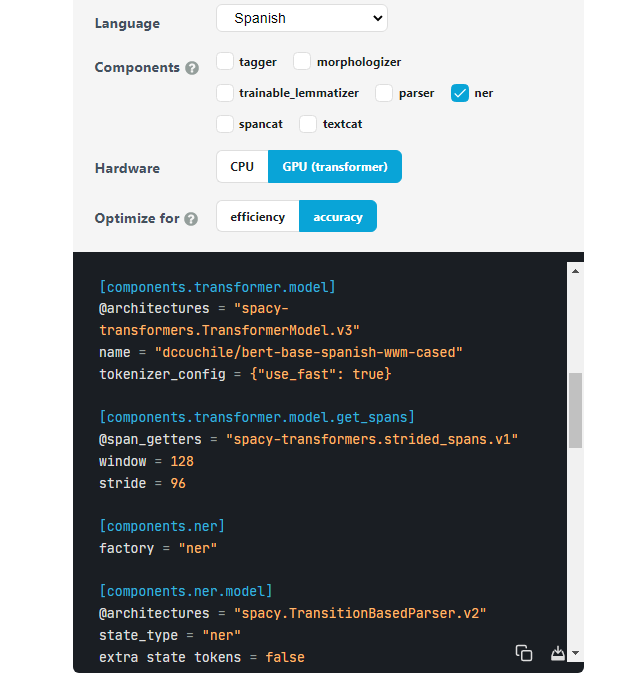

download that base_config file and place in the same diretory

## Now we fill the config file with all the details

In [ ]:
!python -m spacy init fill-config base_config-gpuacc.cfg config.cfg 

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


## Finally Train the NER model

In [ ]:
!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./test.spacy --gpu-id 0

✔ Created output directory: output
ℹ Saving to output directory: output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-09-28 12:04:25,947] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-09-28 12:04:25,959] [INFO] Pipeline: ['transformer', 'ner']
INFO:spacy:Pipeline: ['transformer', 'ner']
[2022-09-28 12:04:25,963] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-09-28 12:04:25,964] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing B

# Integrating the Whisper ASR

In [ ]:
if not path_exists('transcripts'):
    !mkdir transcripts

In [65]:
YouTubeID = 'xOZM-1p-jAk' # ¿Qué es la enfermedad de Crohn y cómo detectarla?
OutputFile = 'test_audio_youtube_5.m4a'


In [66]:
if not path_exists(OutputFile):
    !youtube-dl -o $OutputFile $YouTubeID --extract-audio --restrict-filenames -f 'bestaudio[ext=m4a]'

[youtube] xOZM-1p-jAk: Downloading webpage
[download] Destination: test_audio_youtube_5.m4a
[download] 100% of 3.39MiB in 01:00
[ffmpeg] Correcting container in "test_audio_youtube_5.m4a"
[ffmpeg] Post-process file test_audio_youtube_5.m4a exists, skipping


In [67]:
model_whisper = whisper.load_model("small")
result = model_whisper.transcribe(OutputFile)
print(result["text"])

 A tu salud con María Laura García. Hola amigos, gracias por acompañarnos en estos minutos dedicados a tu salud. Hoy le hablaremos de una enfermedad congénica del sistema nervioso central de carácter progresivo, que causa minusvalía y provoca más de 100 síntomas asociados. Se trata de la enfermedad de Chiari o malformación de Arnalt Chiari, caracterizada por la migración o salida de componentes del cerebro a través del agujero que conecta dicho órgano con la columna, comprimiendo el tallo cerebral. Para conocer detalles de esta rara patología, que afecta mayoritariamente a las mujeres, nos acompaña el neurocirujano, Hermann Schultz. Esto ocurre, puede ser un recién nacido o adolescente con los adultos y la forma de presentación es diferente. En los recién nacidos son niños que se acompañan con otras malformaciones. Por ejemplo, se llama el miel o meningoceles, que es una malformación, que la columna no se cierra en forma adecuada y la médula se sale a través de ella y eso produce un ef

In [68]:
import spacy_transformers
nlp1 = spacy.load(r"/content/output/model-best") #load the best model

doc = nlp1(result["text"])


In [69]:
ents = dict_specialty_keywords_es.keys()


import random
random.seed(38)

colors = {}
for j in ents:
    rand_colors = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
    colors[j] = rand_colors[0]

options = {"ents": list(ents), "colors": colors }

In [70]:
spacy.displacy.render(doc, style='ent',jupyter=True, options=options)

Not Bad, you could improve by more training time or filterrin even more the words.